# PEC 1. Selección de modelos

## 1. Librerías necesarias<a name="ln"></a>

In [1]:
import numpy as np

# Librería para la generación del dataset
from sklearn.datasets import make_classification

# Librerías para el uso de los modelos knn y logistic regression 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Librerías para el uso de pruebas estadísticas
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2, t
from mlxtend.evaluate import paired_ttest_5x2cv, bias_variance_decomp

# Librería para la representación de los resultados
import pandas as pd

## 2. Generación de conjunto de datos sintético<a id="dataset"></a>

Utilizamos la función `make_classification` de `sklearn.datasets` para generar un conjunto de datos sintético diseñado específicamente para un problema de clasificación binaria. A continuación, se describen las características principales del dataset:

### **Parámetros Utilizados**
- **Número de muestras (`n_samples`)**: 1000.
  - El conjunto de datos contiene un total de 1000 observaciones.
  
- **Número de características (`n_features`)**: 10.
  - Cada observación está representada por 10 características.

- **Número de características informativas (`n_informative`)**: 8.
  - Ocho de las características están directamente relacionadas con la clasificación de las clases.

- **Número de características redundantes (`n_redundant`)**: 2.
  - Dos características se derivan de combinaciones lineales de las características informativas, añadiendo correlación al dataset.

- **Número de clases (`n_classes`)**: 2.
  - Es un problema de clasificación binaria.

- **Número de clústeres por clase (`n_clusters_per_class`)**: 3.
  - Cada clase está compuesta por tres clústeres separados.

- **Separación entre las clases (`class_sep`)**: 0.8.
  - La separación entre los clústeres de cada clase no es muy alta.

- **Proporción de las clases (`weights`)**: [0.6, 0.4].
  - La clase 0 representa el 60% de las observaciones, mientras que la clase 1 representa el 40%. Esto introduce un leve desbalance en el dataset.

- **Ruido introducido en las etiquetas (`flip_y`)**: 0.05.
  - El 5% de las etiquetas se aleatorizan, introduciendo ruido para simular errores de clasificación o datos imperfectos.

- **Semilla aleatoria (`random_state`)**: 1.
  - Se establece una semilla para garantizar la reproducibilidad del dataset.

### **Propósito del Dataset**
Este dataset fue diseñado para simular un problema de clasificación binaria con características correlacionadas, clases no perfectamente separables con un leve desbalance de clases. Estas propiedades permiten:
1. Evaluar el rendimiento de clasificadores supervisados como **regresión logística** y **k-nn**.
2. Analizar el impacto de características informativas y redundantes en la clasificación.
3. Probar la robustez de los modelos frente a ruido y desbalance de clases.

### **Distribución del Dataset**
- **Tamaño total**: 1000 observaciones.
- **Distribución de clases**:
  - Clase 0: 600 observaciones (60%).
  - Clase 1: 400 observaciones (40%).

In [2]:
# Generación del dataset sintético
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_classes=2,
    n_clusters_per_class=3,
    class_sep=0.8,
    weights=[0.6, 0.4],
    flip_y=0.05,
    random_state=1
)

# División en conjunto de entrenamiento y prueba (70/30)
# stratify mantiene la proporción de clases en los splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## 3. Definición y entrenamiento de los clasificadores<a id="train"></a>

In [3]:
# Definición de los clasificadores
clf_lr = LogisticRegression(random_state=42, max_iter=1000)
clf_knn = KNeighborsClassifier(n_neighbors=5)

# Entrenamiento de los clasificadores
clf_lr.fit(X_train, y_train)
clf_knn.fit(X_train, y_train)

KNeighborsClassifier()

## 4. Predicciones y cálculo de la precisión<a name="pred"></a>

In [4]:
# Predicciones en el conjunto de prueba
y_pred_lr = clf_lr.predict(X_test)
y_pred_knn = clf_knn.predict(X_test)

# Cálculo de las precisiones
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

## 5. Construcción de la tabla de contingencia para el test de McNemar<a name="tablamac"></a>

In [5]:
# Construcción de la tabla de contingencia para el Test de McNemar
# True: predicción correcta, False: predicción incorrecta
correct_lr = y_pred_lr == y_test
correct_knn = y_pred_knn == y_test

# Cálculo de los valores n00, n01, n10, n11
n00 = np.sum(np.logical_and(correct_lr, correct_knn))
n01 = np.sum(np.logical_and(correct_lr, np.logical_not(correct_knn)))
n10 = np.sum(np.logical_and(np.logical_not(correct_lr), correct_knn))
n11 = np.sum(np.logical_and(np.logical_not(correct_lr), np.logical_not(correct_knn)))

# Construcción de la matriz de confusión para el Test de McNemar
table = np.array([[n00, n01],
                  [n10, n11]])

discordancias = n01 + n10
print(f"Total de discordancias (n01 + n10): {discordancias}")

if discordancias < 10:
    print("Advertencia: El número de discordancias es bajo. El test de McNemar puede no ser fiable.")
else:
    print("El número de discordancias es adecuado para aplicar el test de McNemar.")

Total de discordancias (n01 + n10): 75
El número de discordancias es adecuado para aplicar el test de McNemar.


## 6. Aplicación del test de McNemar<a name="testmac"></a>

In [22]:
# Aplicación del Test de McNemar
result_mcnemar = mcnemar(table, exact=False, correction=True)
chi2_v = result_mcnemar.statistic
p_value_mcnemar = result_mcnemar.pvalue

# Parámetros
alpha = 0.05  # Nivel de significancia
df = 1        # Grados de libertad

critical_value = chi2.ppf(1 - alpha, df)

print(critical_value)

3.841458820694124


## 7. Aplicación del test t pareado 5x2 CV<a name="test5x2"></a>

In [23]:
# Aplicación del Test t pareado 5x2 CV
t_statistic, p_value_ttest = paired_ttest_5x2cv(
    estimator1=LogisticRegression(random_state=42, max_iter=1000),
    estimator2=KNeighborsClassifier(n_neighbors=5),
    X=X, y=y, random_seed=42
)

# Parámetros
alpha = 0.05  # Nivel de significancia
df = 5        # Grados de libertad

# Valor crítico (cola derecha)
critical_value_right = t.ppf(1 - alpha, df)

# Valor crítico para cola izquierda (si es necesario)
critical_value_left = t.ppf(alpha, df)


## 8. Análisis sesgo - varianza<a name="asv"></a>

In [24]:
# Análisis de Sesgo y Varianza para Regresión Logística
avg_expected_error_lr, avg_bias_lr, avg_variance_lr = bias_variance_decomp(
    clf_lr, X_train, y_train, X_test, y_test, 
    loss='0-1_loss', random_seed=42, num_rounds=200
)

# Análisis de Sesgo y Varianza para k-NN
avg_expected_error_knn, avg_bias_knn, avg_variance_knn = bias_variance_decomp(
    clf_knn, X_train, y_train, X_test, y_test, 
    loss='0-1_loss', random_seed=42, num_rounds=200
)

## 9. Representación analítica de los resultados<a name="ra"></a>

### 9.1. Tabla con las precisiones obtenidas por los clasificadores<a name="tpre"></a>

In [25]:
# Resultados de los clasificadores
accuracy_data = {
    'Clasificador': ['Regresión Logística', 'k-NN (k=5)'],
    'Precisión': [accuracy_lr, accuracy_knn]
}
accuracy_df = pd.DataFrame(accuracy_data).round({'Precisión': 3})

# Muestra la tabla de precisiones
display(accuracy_df)

,Clasificador,Precisión
0,Regresión Logística,0.697
1,k-NN (k=5),0.787


### 9.2. Tabla de contingencia para el test de McNemar<a name="tcmac"></a>

In [26]:
# Tabla de contingencia para el Test de McNemar
contingency_table = pd.DataFrame(
    table,
    index=['Regresión Logística Correcta', 'Regresión Logística Incorrecta'],
    columns=['k-NN Correcta', 'k-NN Incorrecta']
)

display(contingency_table)

,k-NN Correcta,k-NN Incorrecta
Regresión Logística Correcta,185,24
Regresión Logística Incorrecta,51,40


### 9.3. Tabla de resultados del test de McNemar<a name="trmac"></a>

In [27]:
# Resultados del Test de McNemar
mcnemar_results = {
    'Estadístico $\chi^2$': [chi2_v],
    'p-value': [p_value_mcnemar],
    'critical value': [critical_value]
}

mcnemar_df = pd.DataFrame(mcnemar_results, index=['Test de McNemar']).round(3)

# Muestra los resultados del Test de McNemar
display(mcnemar_df)

,Estadístico $\chi^2$,p-value,critical value
Test de McNemar,9.013,0.003,3.841


### 9.4. Tabla de resultados del test t pareado 5x2 CV<a name="tr5x2"></a>

In [28]:
# Resultados del Test t pareado 5x2 CV
ttest_results = {
    '|t|': [abs(t_statistic)],
    'p-value': [p_value_ttest],
    'valor crítico derecho': [critical_value_right]
}
ttest_df = pd.DataFrame(ttest_results, index=['Test t pareado 5x2 CV']).round(3)

# Muestra los resultados del Test t pareado 5x2 CV
display(ttest_df)

,|t|,p-value,valor crítico derecho
Test t pareado 5x2 CV,3.425,0.019,2.015


### 9.5. Resultados del análisis de la descomposición sesgo - varianza<a name="trsv"></a>

In [13]:
# Resultados del Análisis de Sesgo y Varianza
bias_variance_data = {
    'Clasificador': ['Regresión Logística', 'k-NN (k=5)'],
    'Sesgo (Bias)': [avg_bias_lr, avg_bias_knn],
    'Varianza': [avg_variance_lr, avg_variance_knn],
    'Error Esperado': [avg_expected_error_lr, avg_expected_error_knn]
}

bias_variance_df = pd.DataFrame(bias_variance_data).round(2)

print("Análisis de Sesgo y Varianza:")
display(bias_variance_df)

Análisis de Sesgo y Varianza:


,Clasificador,Sesgo (Bias),Varianza,Error Esperado
0,Regresión Logística,0.31,0.04,0.31
1,k-NN (k=5),0.22,0.13,0.24


## 10. Representación gráfica de los resultados<a name="rg"></a>

### 10.1. Tabla de contingencia para el test de McNemar<a name="tcgmac"></a>

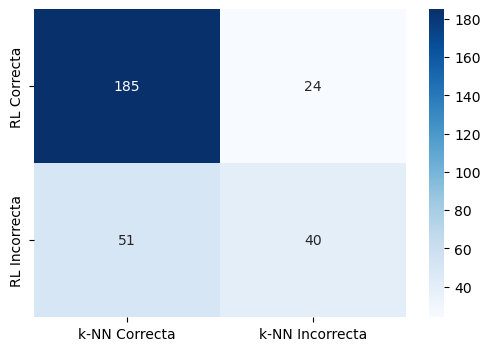

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar los nombres de las filas y columnas
row_labels = ["RL Correcta", "RL Incorrecta"]
col_labels = ["k-NN Correcta", "k-NN Incorrecta"]

plt.figure(figsize=(6, 4))
sns.heatmap(
    contingency_table,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=col_labels,
    yticklabels=row_labels
)
#plt.title('Tabla de Contingencia - Test de McNemar')
plt.savefig('tabla_contingencia_mcnemar_str.png', dpi=300, bbox_inches='tight')
plt.show()

### 10.2. Diagrama de mosaico para el test de McNemar<a name="dmmac"></a>

<Figure size 800x600 with 0 Axes>

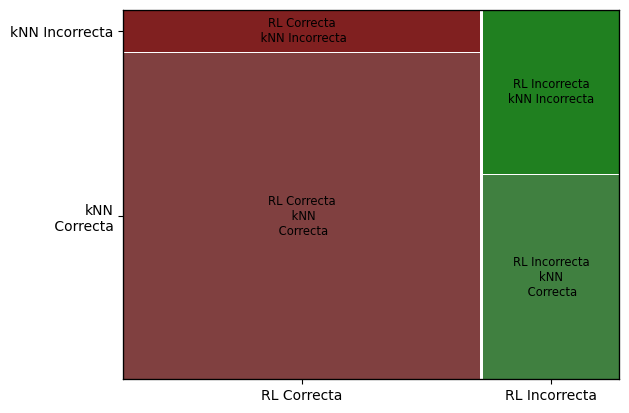

In [15]:
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import pandas as pd

# Crear tabla de contingencia como DataFrame
contingency_table = pd.DataFrame(
    [[192, 25],
     [46, 37]],
    index=['RL Correcta', 'RL Incorrecta'],  # Etiquetas para las filas
    columns=[f'kNN\n Correcta', 'kNN Incorrecta']  # Etiquetas para las columnas
)

# Función personalizada para ajustar etiquetas
def labelizer(key):
    label = " ".join(key)  
    if len(label) > 20:    # Ajustamos la longitud
        if label[2:11] == " Correcta":
            label = "RL" + label[2:11] + "\n" + label[11:]
        else:
            label = "RL" + label[2:13] + "\n" + label[14:]
    return label

# Crear el gráfico de mosaico
plt.figure(figsize=(8, 6))
mosaic(contingency_table.stack(), labelizer=labelizer)  

# Personalizar el gráfico
#plt.title('Diagrama de Mosaico – Test de McNemar', fontsize=14)
plt.savefig('tabla_mosaico_mcnemar_str.png', dpi=300, bbox_inches='tight') 
plt.show()


### 10.3. Distribución de la precisión para el test t pareado 5x2 CV<a name="dp5x2"></a>

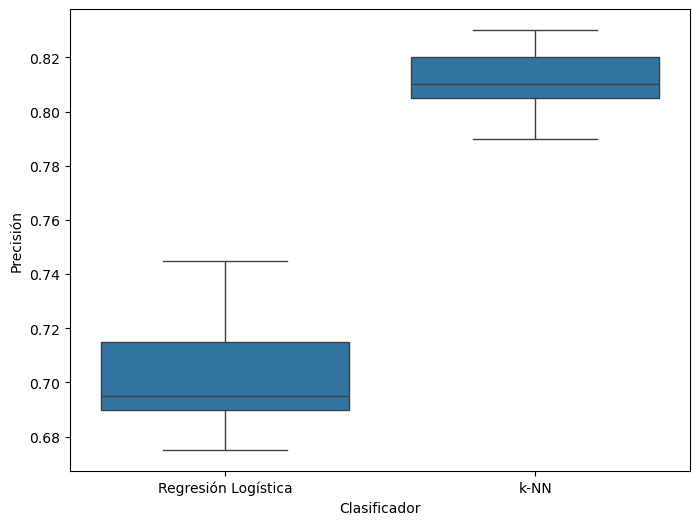

In [16]:
from sklearn.model_selection import cross_val_score

scores_lr = cross_val_score(clf_lr, X, y, cv=5)
scores_knn = cross_val_score(clf_knn, X, y, cv=5)

scores_df = pd.DataFrame({
    'Regresión Logística': scores_lr,
    'k-NN': scores_knn
})

scores_df_melted = scores_df.melt(var_name='Clasificador', value_name='Precisión')

plt.figure(figsize=(8, 6))
sns.boxplot(x='Clasificador', y='Precisión', data=scores_df_melted)
#plt.title('Distribución de Precisión - Validación Cruzada')
plt.savefig('distribucion_precision_5x2_str.png', dpi=300, bbox_inches='tight') 
plt.show()


### 10.4. Precisión a lo largo de las particiones para el test t pareado 5x2 CV<a name="pp5x2"></a>

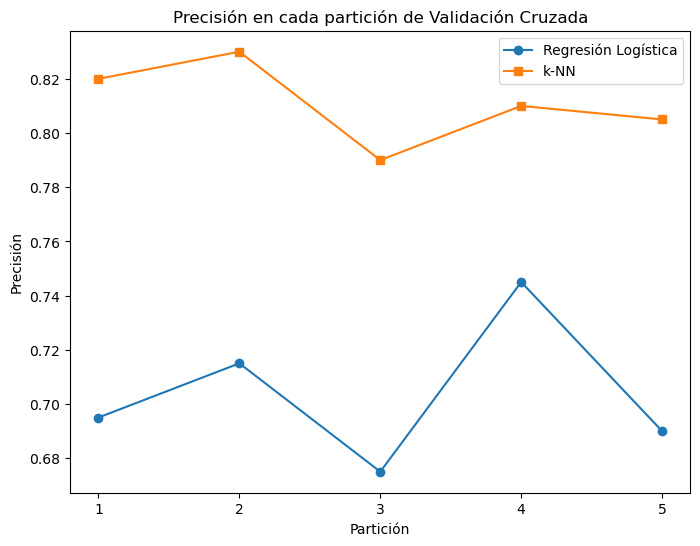

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), scores_lr, marker='o', label='Regresión Logística')
plt.plot(range(1, 6), scores_knn, marker='s', label='k-NN')
plt.xlabel('Partición')
plt.ylabel('Precisión')
plt.title('Precisión en cada partición de Validación Cruzada')

# Configurar los valores del eje x para mostrar solo números enteros de los folds
plt.xticks(ticks=range(1, 6), labels=range(1, 6))

plt.legend()
plt.savefig('precision_particiones_5x2_str.png', dpi=300, bbox_inches='tight')  # Guardar imagen
plt.show()


### 10.5. Diferencias de precisión entre los clasificadores para el test t pareado 5x2 CV<a name="dpa5x2"></a>

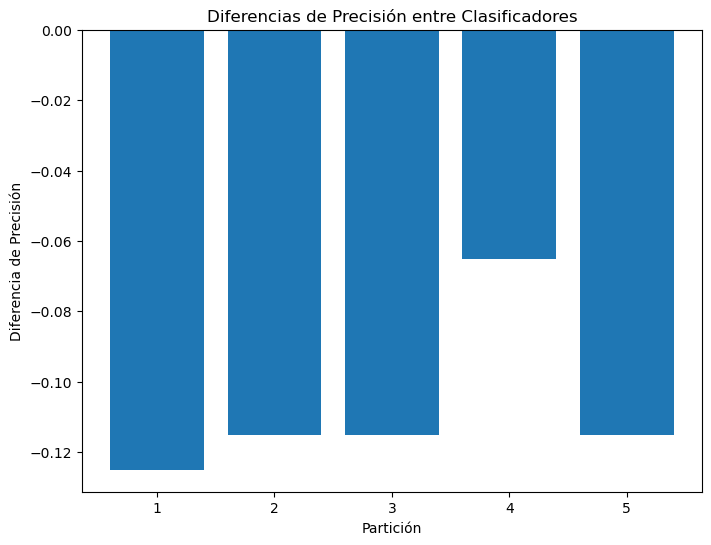

In [18]:
differences = scores_lr - scores_knn

plt.figure(figsize=(8, 6))
plt.bar(range(1, 6), differences)
plt.xlabel('Partición')
plt.ylabel('Diferencia de Precisión')
plt.title('Diferencias de Precisión entre Clasificadores')
plt.savefig('diferencias_precision_particiones_5x2_str.png', dpi=300, bbox_inches='tight') 
plt.show()
